# Exercise 1: Structuring a given code

### Original

In [1]:
file_path = input("Enter the path to the CSV file: ")
records = []
with open(file_path, 'r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        records.append(row)

total = sum(float(record['Grade']) for record in records)
average = total / len(records)

print(f"Average Grade: {average}")
print("--------------------")

filtered_records = [record for record in records if float(record['Grade']) >= 80.0]

print("Student Report")
print("--------------")
for record in filtered_records:
    print(f"Name: {record['Name']}")
    print(f"Grade: {record['Grade']}")
    print("--------------------")

FileNotFoundError: [Errno 2] No such file or directory: 'asd'

### Structured

##### Functions

In [ ]:
def get_records(path_to_csv: str) -> list[dict[str, str]]:
    """Returns a list of records based on a given path to a CSV.
    
    Arguments:
        path_to_csv (str): The path (relative to the CWD) to a CSV file containting the records.
    Returns:
        list: The records read from the afformentioned file.
    """
    
    records = []
    
    # Read each line of the CSV
    with open(file_path, 'r') as file:
        csv_reader = csv.DictReader(file)
        for row in csv_reader:
            records.append(row)
            
    # Return records
    return records

In [ ]:
def get_average_grade(records: list[str]) -> float:
    """Return the average grade for a given list of student records.

    Args:
        records (list): The list of student records.

    Returns:
        float: The average grade.
    """
    
    # Convert grade to float for each records and calculate the average.
    return sum(float(record['Grade']) for record in records) / len(records)

In [4]:
def print_underlined(string: str) -> None:
    """Prints a string followed by dashed on the next line.

    Args:
        string (str): The String to print underlined.
    """
    
    # Determine max line length
    lines = string.split('\n')
    max_line_len = max([len(line) for line in lines])

    # Print with underline
    print(string)
    print("-" * max_line_len)

##### Main

In [ ]:
# Get records based on a user-entered path to a CSV file.
records = get_records(input("Enter the path to the CSV file: "))

# Calculate and print the average grade.
print_underlined(get_average_grade(records))

# Print student reports where the grade is 8 or higher
min_grade = 8
print_underlined("-- Student Reports --")
for record in records:
    grade = record['Grade']
    if float(grade) >= min_grade:
        print_underlined(f"Name: {record['Name']}\nGrade: {record['Grade']}")

# Exercise 2: Mandelbrot visualisation

In [ ]:
# Settings
diverging_index_limit = 100
range_x = (-1.5, 0.5)
range_y = (-1, 1)


def draw_mandel(width):
    

In [ ]:
lajsdlkjasjdasdjkahwidwoiad

# Exercise 3: Google PageRank algorithm and the worldwide web

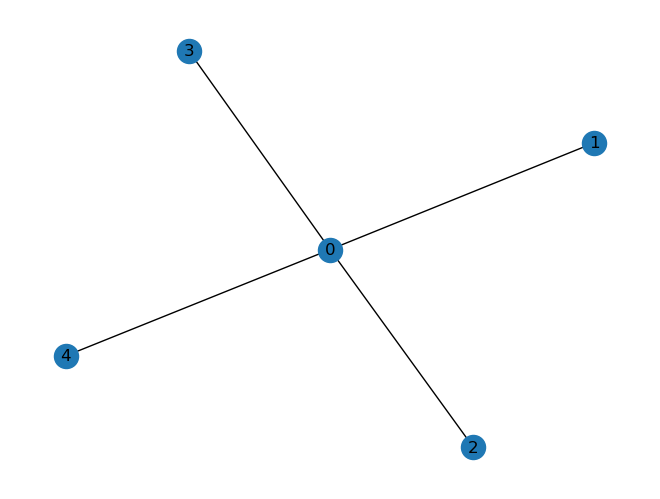

In [30]:
import networkx as nx
import matplotlib.pyplot as plt
n0 = 5
M = 4 
N = 400
g = nx.barabasi_albert_graph(n0, M)
nx.draw(g, with_labels=True)
plt.show()